In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib


# 1. Data preprocessing
__IMPORTANT__
 - sort by ascending order of date

In [2]:
data_path = '/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/data/raw_data/HistoricalData.csv'

df = pd.read_csv(data_path, index_col='Date', parse_dates=True) # make the date column the index and convert it to datetime
df = df.sort_values(by='Date',ascending=True) # sort the data by date
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-11-25,$0.5142,189934400,$0.5135,$0.518,$0.5125
2014-11-26,$0.5229,219265360,$0.5112,$0.5235,$0.511
2014-11-28,$0.5242,124831240,$0.5247,$0.5273,$0.5201
2014-12-01,$0.5145,190040280,$0.522,$0.525,$0.5138
2014-12-02,$0.5152,245951920,$0.514,$0.5175,$0.5093


In [3]:
print(df.loc['2019-01-22']) 

Close/Last      $3.7193
Volume        660230000
Open            $3.8928
High            $3.9045
Low             $3.6888
Name: 2019-01-22 00:00:00, dtype: object


## 1.1) Data Cleaning 

In [4]:
# remove the doller symbols in each column

df["High"] = df["High"].str.replace("$", "")
df["Low"] = df["Low"].str.replace("$", "")
df["Open"] = df["Open"].str.replace("$", "")
df["Close/Last"] = df["Close/Last"].str.replace("$", "")

# convert all vlues to float

df["High"] = df["High"].astype(float)
df["Low"] = df["Low"].astype(float)
df["Open"] = df["Open"].astype(float)
df["Close/Last"] = df["Close/Last"].astype(float)


df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-11-25,0.5142,189934400,0.5135,0.5180,0.5125
2014-11-26,0.5229,219265360,0.5112,0.5235,0.5110
2014-11-28,0.5242,124831240,0.5247,0.5273,0.5201
2014-12-01,0.5145,190040280,0.5220,0.5250,0.5138
2014-12-02,0.5152,245951920,0.5140,0.5175,0.5093


In [5]:
df["High"].dtype # check the data type of the column


dtype('float64')

In [6]:
# take a look at the percentage change from high to low relative to the opening price

df["Range"] = (df["High"] - df["Low"])/ df["Open"] # add a new column to the dataframe
df.pop("Volume") # remove the volume column
df.head()


,Close/Last,Open,High,Low,Range
Date,,,,,
2014-11-25,0.5142,0.5135,0.5180,0.5125,0.010711
2014-11-26,0.5229,0.5112,0.5235,0.5110,0.024452
2014-11-28,0.5242,0.5247,0.5273,0.5201,0.013722
2014-12-01,0.5145,0.5220,0.5250,0.5138,0.021456
2014-12-02,0.5152,0.5140,0.5175,0.5093,0.015953


<Axes: xlabel='Date'>

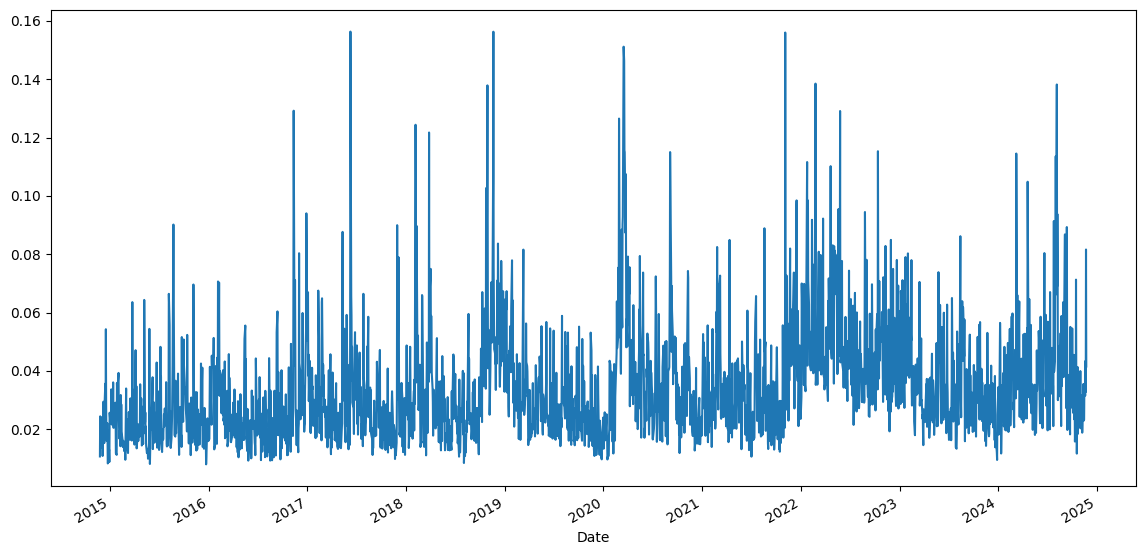

In [7]:
df["Range"].plot(figsize=(14,7)) # plot the range column

<Axes: xlabel='Date'>

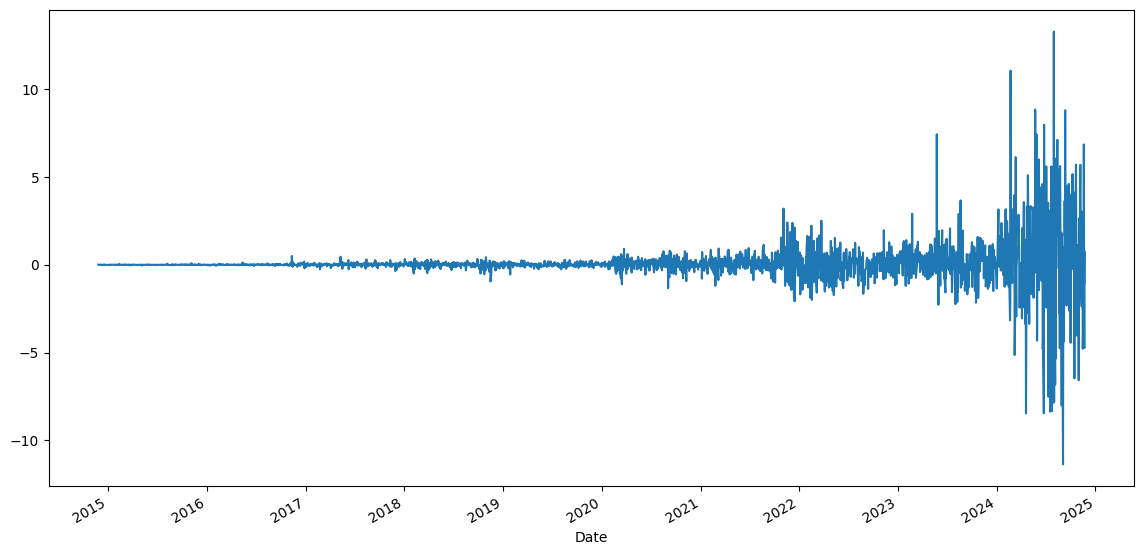

In [8]:
df["abs_change"] = df["Close/Last"].diff() # difference between the closing price of the current day and the previous day
df["abs_change"].plot(figsize=(14,7)) # plot the absolute change column

### We can see early values have very small change in absolute value mainly due to how small the stock prcies were 
 - means lstm model will not see these values 
 - percentage change between the current and previous day

In [9]:
df["Change(%)"] = df["Close/Last"].pct_change() # percentage change in the closing price from the previous day
df.dropna(inplace=True) # remove rows with NaN values
df.head()

,Close/Last,Open,High,Low,Range,abs_change,Change(%)
Date,,,,,,,
2014-11-26,0.5229,0.5112,0.5235,0.5110,0.024452,0.0087,0.016919
2014-11-28,0.5242,0.5247,0.5273,0.5201,0.013722,0.0013,0.002486
2014-12-01,0.5145,0.5220,0.5250,0.5138,0.021456,-0.0097,-0.018504
2014-12-02,0.5152,0.5140,0.5175,0.5093,0.015953,0.0007,0.001361
2014-12-03,0.5285,0.5178,0.5287,0.5162,0.024141,0.0133,0.025815


Date
2014-11-26    0.0087
2014-11-28    0.0013
2014-12-01   -0.0097
2014-12-02    0.0007
2014-12-03    0.0133
               ...  
2024-11-18   -1.8300
2024-11-19    6.8600
2024-11-20   -1.1200
2024-11-21    0.7800
2024-11-22   -4.7200
Name: abs_change, Length: 2515, dtype: float64

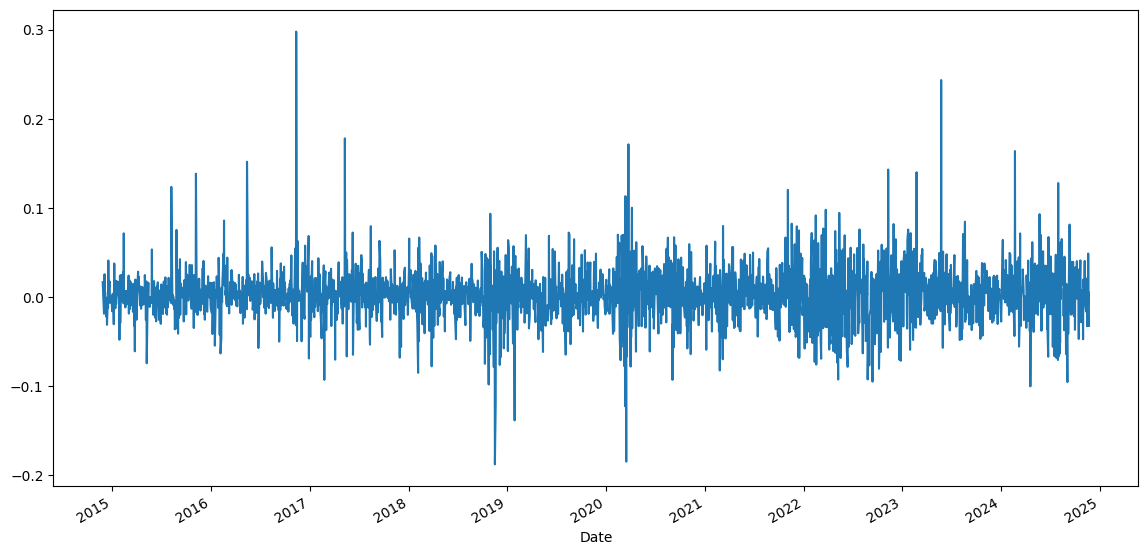

In [10]:
df["Change(%)"].plot(figsize=(14,7)) # plot the percentage change column
df.pop("abs_change") # remove the absolute change column


In [11]:
df.describe() # get the summary statistics of the dataframe

,Close/Last,Open,High,Low,Range,Change(%)
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000
mean,19.470108,19.468726,19.824741,19.079882,0.034078,0.002700
std,30.200658,30.226197,30.769259,29.583985,0.019012,0.030582
min,0.478400,0.481300,0.487500,0.473500,0.008005,-0.187557
25%,3.342900,3.352000,3.436400,3.254550,0.021048,-0.012402
50%,6.331300,6.319800,6.415000,6.242600,0.029201,0.002576
75%,20.368900,20.379100,20.599000,20.049500,0.041841,0.017558
max,148.880000,149.350000,152.890000,146.260000,0.156295,0.298058


# IMPORTANT
 - make sure data is in ascending order

In [12]:

df = df.sort_values(by="Date", ascending=True) # sort the dataframe by date
df.head()

,Close/Last,Open,High,Low,Range,Change(%)
Date,,,,,,
2014-11-26,0.5229,0.5112,0.5235,0.5110,0.024452,0.016919
2014-11-28,0.5242,0.5247,0.5273,0.5201,0.013722,0.002486
2014-12-01,0.5145,0.5220,0.5250,0.5138,0.021456,-0.018504
2014-12-02,0.5152,0.5140,0.5175,0.5093,0.015953,0.001361
2014-12-03,0.5285,0.5178,0.5287,0.5162,0.024141,0.025815


# 1.2 Normalising and defining features


In [13]:
# define features and target variable
feature_cols = ["Close/Last","Change(%)"]
target_col = "Close/Last"

# initialize the MinMaxScaler
scalar = MinMaxScaler(feature_range=(0, 1))

# normalize the data
scaled_features = scalar.fit_transform(df[feature_cols])

# save the scaler object
joblib.dump(scalar, 'scaler.pkl')

scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)


scaled_df.head()    

,Close/Last,Change(%)
0,0.000300,0.421067
1,0.000309,0.391345
2,0.000243,0.348120
3,0.000248,0.389027
4,0.000338,0.439385


In [14]:
# store the scaled data into a new csv file

saved_path = '/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/data/preprocessed_data/scaled_nvidia_stock.csv'

scaled_df.to_csv(saved_path, index=False)